### Plot performance across experiments

## Imports

In [7]:
import os
import random
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
import random
import torch

from cyclops.processors.column_names import EVENT_NAME
from cyclops.utils.file import load_pickle
from models.temporal.optimizer import Optimizer, EarlyStopper
from models.temporal.utils import (
    get_data,
    get_device,
    get_temporal_model,
    load_checkpoint,
)
import seaborn as sns
from models.temporal.metrics import print_metrics_binary
from drift_detection.gemini.utils import prep, get_use_case_params, import_dataset_hospital, random_shuffle_and_split
from drift_detection.drift_detector.plotter import plot_pretty_confusion_matrix
from drift_detection.gemini.constants import DIAGNOSIS_DICT, HOSPITALS

# Choose dataset and use-case

In [3]:
DATASET = "gemini"
USE_CASE = "mortality"
DIR=os.path.join("/mnt/nfs/project/delirium/drift_exp/OCT-18-2022/",DATASET,USE_CASE,"saved_models")
use_case_params = get_use_case_params(DATASET, USE_CASE)


output_dim = 1
batch_size = 64
input_dim = 91
timesteps = 6
hidden_dim = 64
layer_dim = 2
dropout = 0.2
n_epochs = 128
learning_rate = 2e-3
weight_decay = 1e-6
last_timestep_only = False
device = get_device()
model_params = {
    "device": device,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "layer_dim": layer_dim,
    "output_dim": output_dim,
    "dropout_prob": dropout,
    "last_timestep_only": last_timestep_only,
}

model_name = "lstm"

/mnt/nfs/home/subasriv/.cache/pypoetry/virtualenvs/cyclops-KKtuQLwg-py3.9/lib/python3.9/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


## Load train/val/test inputs and labels

In [ ]:
id_filepath = os.path.join(os.getcwd(),'../output',USE_CASE+'_id_exp_performance.txt')
ood_filepath = os.path.join(os.getcwd(),'../output',USE_CASE+'_ood_exp_performance.txt')
if os.path.exists(id_filepath) and os.path.exists(ood_filepath):
    id_reps = pd.read_csv(id_filepath, sep='\t')
    ood_reps = pd.read_csv(ood_filepath, sep='\t')
else:
    id = list()
    ood = list()
    exp = list()
    for seed in range(1,6):

        for ID in ["hosp_type_academic","hosp_type_community","seasonal_summer","seasonal_winter","day","night"]:

            print(ID, " Run", seed)
            torch.manual_seed(seed)
            random.seed(seed)
            np.random.seed(seed)

            X_train_vec = load_pickle(use_case_params.TAB_VEC_COMB + "comb_train_X_"+ID)
            y_train_vec = load_pickle(use_case_params.TAB_VEC_COMB + "comb_train_y_"+ID)
            X_val_vec = load_pickle(use_case_params.TAB_VEC_COMB + "comb_val_X_"+ID)
            y_val_vec = load_pickle(use_case_params.TAB_VEC_COMB + "comb_val_y_"+ID)
            X_test_vec = load_pickle(use_case_params.TAB_VEC_COMB + "comb_test_X_"+ID)
            y_test_vec = load_pickle(use_case_params.TAB_VEC_COMB + "comb_test_y_"+ID)

            X_train = prep(X_train_vec.data)
            y_train = prep(y_train_vec.data)
            X_val = prep(X_val_vec.data)
            y_val = prep(y_val_vec.data)
            X_test = prep(X_test_vec.data)
            y_test = prep(y_test_vec.data)

            (X_train, y_train), (X_val, y_val) = random_shuffle_and_split(X_train, y_train, X_val, y_val)

            train_dataset = get_data(X_train, y_train)
            train_loader = train_dataset.to_loader(batch_size, shuffle=True)

            val_dataset = get_data(X_val, y_val)
            val_loader = val_dataset.to_loader(batch_size, shuffle=True)

            test_dataset = get_data(X_test, y_test)
            test_loader = test_dataset.to_loader(batch_size, shuffle=True)

            model = get_temporal_model(model_name, model_params).to(device)

            if random:
                filepath=os.path.join(DIR,"random_reweight_positive"+"_"+model_name+"_"+str(seed)+".pt")
            else:
                filepath=os.path.join(DIR,ID+"_reweight_positive"+"_"+model_name+"_"+str(seed)+".pt")

            model, opt, n_epochs = load_checkpoint(filepath, model)

            y_val_labels, y_val_pred_values, y_val_pred_labels = opt.evaluate(
                val_loader
            )

            y_val_pred_values = y_val_pred_values[y_val_labels != -1]
            y_val_pred_labels = y_val_pred_labels[y_val_labels != -1]
            y_val_labels = y_val_labels[y_val_labels != -1]

            val_pred_metrics = print_metrics_binary(y_val_labels, y_val_pred_values, y_val_pred_labels, 0)


            y_test_labels, y_pred_values, y_pred_labels = opt.evaluate(
                test_loader
            )

            y_pred_values = y_pred_values[y_test_labels != -1]
            y_pred_labels = y_pred_labels[y_test_labels != -1]
            y_test_labels = y_test_labels[y_test_labels != -1]

            test_pred_metrics = print_metrics_binary(y_test_labels, y_pred_values, y_pred_labels, 0)

            id.append(val_pred_metrics)
            ood.append(test_pred_metrics)
            exp.append(ID)

    id_reps = pd.DataFrame({k: [d.get(k) for d in id] for k in set().union(*id)})
    id_reps['Experiment'] = exp
    ood_reps = pd.DataFrame({k: [d.get(k) for d in ood] for k in set().union(*ood)})
    ood_reps['Experiment'] = exp
    
id_reps['Distribution'] = "ID"    
ood_reps['Distribution'] = "OOD"
id_auroc = id_reps[['auroc','Experiment','Distribution']]
id_auroc = pd.melt(id_auroc, id_vars=['Experiment','Distribution'],value_vars=['auroc'])
ood_auroc = ood_reps[['auroc','Experiment','Distribution']]
ood_auroc = pd.melt(ood_auroc, id_vars=['Experiment','Distribution'], value_vars=['auroc'])
plot_metrics = pd.concat([id_auroc,ood_auroc])
plot_metrics = plot_metrics.assign(variable=plot_metrics.variable.map({'auroc':'AUROC'}))

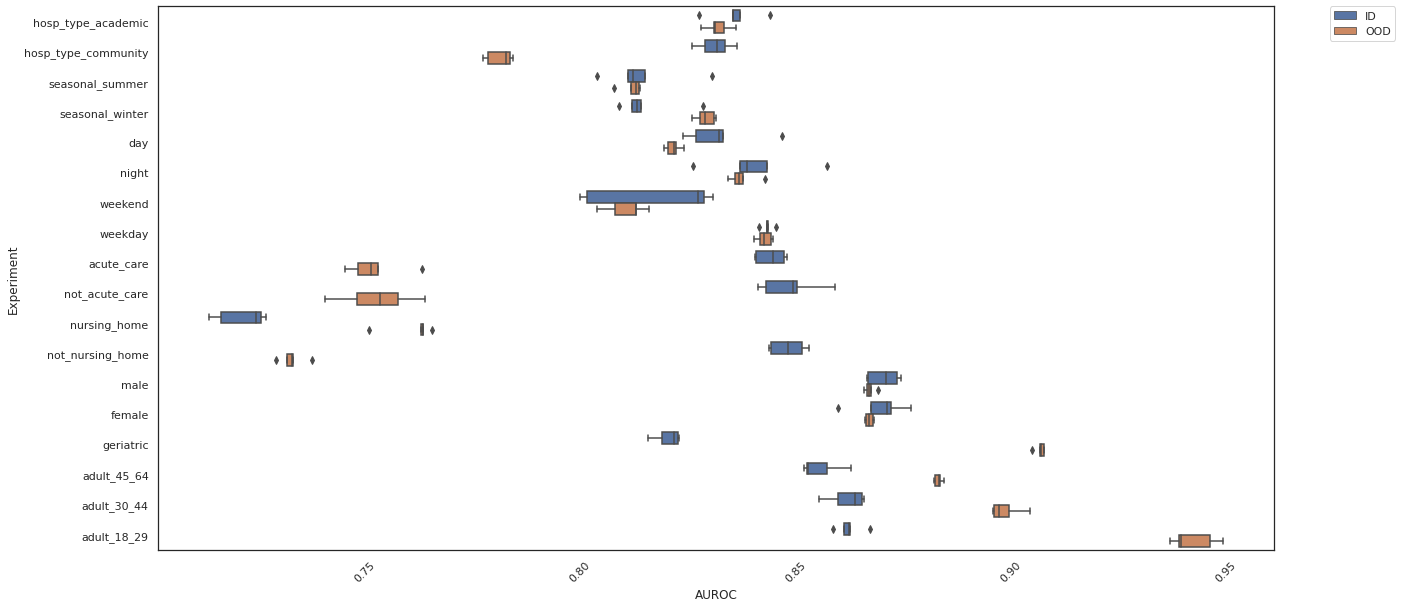

In [8]:
from statannotations.Annotator import Annotator

plot_metrics = pd.read_csv('random_drift_performance_auroc_split.csv')  
hue_plot_params = {
    'data': plot_metrics,
    'y': 'Experiment',
    'x': 'value',
    "order": ["hosp_type_academic","hosp_type_community","seasonal_summer","seasonal_winter","day","night","weekend","weekday","acute_care","not_acute_care","nursing_home","not_nursing_home","male","female","geriatric","adult_45_64","adult_30_44","adult_18_29"],
    "hue": "Distribution",
    "hue_order": ["ID","OOD"],
}
pairs = [
    [('hosp_type_academic', 'ID'), ('hosp_type_academic', 'OOD')],
    [('hosp_type_community', 'ID'),('hosp_type_community', 'OOD')],
    [('day', 'ID'), ('day', 'OOD')],
    [('night', 'ID'), ('night', 'OOD')],
    [('weekday', 'ID'), ('weekday', 'OOD')],
    [('weekend', 'ID'), ('weekend', 'OOD')],
    [('acute_care', 'ID'), ('acute_care', 'OOD')],
    [('not_acute_care', 'ID'), ('not_acute_care', 'OOD')],
    [('nursing_home', 'ID'), ('nursing_home', 'OOD')],
]

sns.set(rc={'figure.figsize':(20,10)})
sns.set(style="darkgrid")
sns.set_style(style='white')
ax = sns.boxplot(**hue_plot_params).set(
    ylabel="Experiment", 
    xlabel="AUROC"
)
#annotator = Annotator(ax, pairs, **hue_plot_params)
#annotator.configure(test="Mann-Whitney").apply_and_annotate()
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)